In [98]:
from ThesisPackage.Environments.collectors.collectors_env_discrete_onehot import Collectors
from ThesisPackage.RL.Centralized_PPO.multi_ppo import PPO_Multi_Agent_Centralized
from ThesisPackage.RL.Decentralized_PPO.util import flatten_list, reverse_flatten_list_with_agent_list
from ThesisPackage.Wrappers.vecWrapper import PettingZooVectorizationParallelWrapper
import torch
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [99]:
def make_env(sequence_length=1, max_episode_steps=0):
    vocab_size = 4
    env = Collectors(width=20, height=20, vocab_size=vocab_size, sequence_length=sequence_length, max_timesteps=max_episode_steps, timestep_countdown=15)
    # env = ParallelFrameStack(env, 4)
    return env

In [100]:
def load(path="models/checkpoints", sequence_length=2):
    env = make_env(sequence_length)
    models = {}
    for model in os.listdir(path):
        if f"collect_seq_{sequence_length}" in model:
            try:
                state_dict = torch.load(os.path.join(path, model))
                timestamp = model.split("_")[-1]
                timestamp = int(timestamp.split(".")[0])
                agent = PPO_Multi_Agent_Centralized(env, device="cpu")
                agent.agent.load_state_dict(state_dict)
                models[timestamp] = agent
            except:
                pass
    return models

In [101]:
def plot_language_saliencies(full_saliences, path=None):
    plt.figure(figsize=(20, 5))  # Adjust figure size to make it more readable

    plot_saliences = full_saliences.reshape(full_saliences.shape[0], -1)

    plt.plot(plot_saliences[:, -1], label='Channel 2')
    plt.plot(plot_saliences[:, -2], label="Channel 1")
    # plt.plot(saliencies)
    plt.title('Saliency of language channel')
    plt.xlabel('Timestep')
    plt.ylabel('Saliency Sum')
    plt.legend()
    if path != None:
        plt.savefig(path)
    else:
        plt.show()

In [102]:
import copy

def record_data(env, data):
    data["direction_1"].append(copy.deepcopy(env.players["player_1"].get_direction()))
    data["direction_2"].append(copy.deepcopy(env.players["player_2"].get_direction()))
    data["player_1"].append(copy.deepcopy(env.players["player_1"].get_position()))
    data["player_2"].append(copy.deepcopy(env.players["player_2"].get_position()))
    for i in range(env.num_targets):
        if len(env.targets) > i:
            data[f"target_{i}"].append(copy.deepcopy(env.targets[i].get_position()))
        else:
            data[f"target_{i}"].append(None)
    return data

In [103]:
def perturbation(inputs, model, vocab_size, sequence_length):
    
    # Extract environment inputs
    environment_inputs = inputs[:, :-1 * vocab_size * sequence_length]

    # Extract original logits
    inputs = torch.tensor(inputs, dtype=torch.float32)
    original_logits = model(inputs)
    original_logits = F.softmax(original_logits, dim=1).detach().numpy()
    original_logits = F.log_softmax(torch.tensor(original_logits), dim=1).detach()

    perturbation_logits = []
    for token in range(vocab_size):
        # One-hot encoded sequence of tokens
        utterances = np.array([token for _ in range(sequence_length)])
        utterances = np.eye(vocab_size)[utterances].flatten()
        utterances = np.expand_dims(utterances, axis=0)
        utterances = np.repeat(utterances, inputs.shape[0], axis=0)

        # Concatenate environment inputs with utterances
        perturbation_inputs = np.concatenate((environment_inputs, utterances), axis=1)
        perturbation_inputs = torch.tensor(perturbation_inputs, dtype=torch.float32)

        # Get logits for perturbed inputs
        current_logits = model(perturbation_inputs).detach().numpy()
        current_logits = F.softmax(torch.tensor(current_logits), dim=1).detach().numpy()

        perturbation_logits.append(current_logits)

    divergences = []
    for input_array in perturbation_logits:
        kl_divergences = []
        for i in range(len(input_array)):
            q = F.softmax(torch.tensor(input_array[i]), dim=0)
            kl_div = F.kl_div(original_logits, q, reduction='batchmean').item()
            kl_divergences.append(kl_div)

        divergences.append(kl_divergences)
    max_divergences = np.max(divergences, axis=0)
    return max_divergences

In [104]:
def test_perturbation_saliency(env, agent, epochs=1, tracking_agent="player_1"):
    language_importances = []

    obs, info = env.reset()
    state = env.state()
    average_length = []
    tokens = []
    data = {"player_1": [], "player_2": [], "direction_1":[], "direction_2":[], "target_0":[], "target_1":[], "target_2":[]}

    for i in range(epochs):
        timestep = 0
        while True:
            timestep += 1
            tokens.append(obs[tracking_agent][-1 * env.sequence_length:])
            obs = [obs]
            state = [state]
            obs = np.array(flatten_list(obs))
            state = np.array(flatten_list(state))

            data = record_data(env, data)
            
            # integrated_grads = smoothgrad(obs_track, agent.agent.actor, 0, sigma=1.0, steps=30)
            language_perturbation = perturbation(obs, agent.agent.actor, env.vocab_size, env.sequence_length)
            language_importances.append(language_perturbation)

            obs = torch.tensor(obs, dtype=torch.float32)
            state = torch.tensor(state, dtype=torch.float32)
            with torch.no_grad():
                actions, _, _, _ = agent.agent.get_action_and_value(obs, state)
                actions = reverse_flatten_list_with_agent_list(actions, agent.agents)

            actions = actions[0]
            actions = {agent: action.cpu().numpy() for agent, action in actions.items()}

            obs, _, truncations, terminations, infos = env.step(actions)
            state = env.state()

            if any([truncations[agent] or terminations[agent] for agent in env.agents]):
                average_length.append(timestep)
                obs, info = env.reset()
                state = env.state()
                break
    return np.array(language_importances), data

In [105]:
num_steps = 10000
models = {}
for i in [1, 2, 3, 4]:
    agents = load("/Users/cowolff/Documents/GitHub/ma.pong_rl/models/checkpoints_collectors_2/models/checkpoints", sequence_length=i)
    models[i] = agents
agent_indizes = list(agents.keys())
agent_indizes.sort()
max_steps = 512
env = make_env(max_episode_steps=max_steps)

/Users/cowolff/miniconda3/envs/thesis/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [106]:
current_agent = models[1][agent_indizes[-1]]
length = 0
while length < max_steps:
    importances, data = test_perturbation_saliency(env, current_agent, epochs=1)
    length = len(importances)

print(len(importances))

513


In [107]:
import matplotlib.pyplot as plt
import os

path = "/Users/cowolff/Documents/GitHub/ma.pong_rl/Plotting/Screenshot_Plots/"
# Remove first all files from the directory
for file in os.listdir(path):
    os.remove(os.path.join(path, file))

def plot_importances(data, title):
    # Plot the two lines
    plt.figure(figsize=(14, 4))
    plt.plot(data[:, 0], label='Agent 1')
    plt.plot(data[:, 1], label='Agent 2')
    plt.title(title)
    ax = plt.gca()
    ax.set_xlim([0, len(data)])
    ax.set_ylabel('KL Divergence')
    ax.set_xlabel('Timestep')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"/Users/cowolff/Documents/GitHub/ma.pong_rl/Plotting/Screenshot_Plots/{title}.pdf")

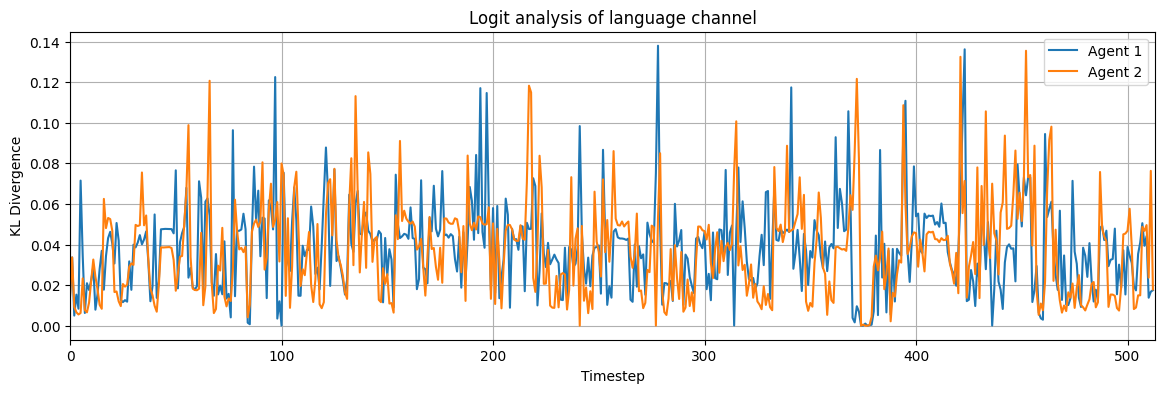

In [108]:
plot_importances(importances, "Logit analysis of language channel")

In [109]:
import pygame

pygame.init()
window_size = 600  # Set the size of the window
cell_size = window_size // max(env.width, env.height)
screen = pygame.display.set_mode((env.width * cell_size, env.height * cell_size))
pygame.display.set_caption('Pong Environment')
clock = pygame.time.Clock()

def render_pygame(env, data, index, mode='pygame'):
    # Initialize PyGame if variable already exists

    # Set screen background and basic colors
    screen.fill((0, 150, 0))
    player_color = (255, 0, 0)  # Colors for paddles
    target_color = (160, 160, 160)

    # Draw paddles
    player_widt = cell_size

    targets = [data["target_0"][index], data["target_1"][index], data["target_2"][index]]
    players = {"player_1": {"position": data["player_1"][index], "direction": data["direction_1"][index]}, "player_2": {"position": data["player_2"][index], "direction": data["direction_2"][index]}}

    for target_pos in targets:
        if target_pos is not None:
            pygame.draw.circle(screen,target_color, (target_pos[0] * cell_size + cell_size // 2, target_pos[1] * cell_size + cell_size // 2), cell_size // 2)

    # Draw the players
    for agent, player_data in players.items():
        pos = player_data["position"]
        direction = player_data["direction"]
        pygame.draw.rect(screen, player_color, (pos[0] * cell_size, pos[1] * cell_size, cell_size, cell_size))
        pygame.draw.rect(screen, player_color, ((pos[0] + direction[0]) * cell_size, (pos[1] + direction[1]) * cell_size, cell_size * 0.5, cell_size * 0.5))

    # Update the display
    pygame.display.flip()

    # Save image
    pygame.image.save(screen, f"/Users/cowolff/Documents/GitHub/ma.pong_rl/Plotting/Screenshot_Plots/collector_{index}.png")

    # Handle quitting from the window
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            pygame.quit()

In [110]:
plot_saliences = np.sum(importances, axis=1)

indices = np.argsort(-plot_saliences)[:20]
print(indices)
print(plot_saliences[indices])

[423 394 452 421 278  66  97 135 395 194 217 197 341 218 464 252 422 125
 368 101]
[0.20749325 0.20598436 0.19972927 0.19382286 0.19108366 0.1749628
 0.17466455 0.17320692 0.17070982 0.17053337 0.16586194 0.16467692
 0.16431088 0.16266342 0.15912237 0.15876676 0.15729259 0.15432989
 0.15385538 0.14964437]


In [ ]:
while True:
    for index in indices:
        render_pygame(env, data, index)
        time.sleep(1.0)

KeyboardInterrupt: 

: 